# Difference between Human and Mouse Dataset: robustness using silhouette persistence

This notebook implements the full analysis pipeline for comparing neuronal morphologies between two groups (human and mouse) using tools from Topological Data Analysis (TDA). The goal is to identify robust, interpretable structural differences based on topological summaries of dendritic architecture.

The methodology follows these main steps:

1. Preprocessing
   - Load and validate neuronal reconstructions.
   - Compute persistence diagrams (e.g., in homology dimension 0).
   - Convert diagrams into persistence silhouettes.
2. Compute Group Means
   - Calculate the average persistence silhouette for each group.
3. Build Confidence Bands
   - Use bootstrap resampling to estimate variability and construct confidence bands for the mean silhouettes.
4. Quantify Effect Sizes
    - Compute $L^2$ distance between the group means.
    - Identify regions of maximal difference.
5. Perform Statistical Testing
    - Run a two-sample permutation test to assess the significance of the observed topological differences.
6. Visualization & Interpretation
    - Plot mean functions, confidence bands, and difference curves.
    - Discuss findings in light of biological relevance.

This topological approach enables a principled, multiscale comparison of tree-like neuronal structures beyond traditional morphometric features.

In [16]:
import tmd
from tmd.view import plot
from tmd.view import view

import gtda
from gtda.diagrams import Silhouette

import matplotlib.pyplot as plt
import numpy as np
import os
import functions as fcts

## 1. Preprocessing

The data of Humans and Mices are separated in two distinct folders. Because the structure of a tree is not supposed to have cycle, we treat the data in Homology Dimension 0.

### Loading and checking the data

In [6]:
data_folder = "Data/ExamplesL23PC"
folders_to_treat = ['Human','Mouse']

In [7]:
grouped_neurons = fcts.check_and_load_neurons(data_folder, folders_to_treat)

Folder: Human
Neurons loaded: 186
Total files in folder: 187
.asc files in folder: 186
Failed to load: 0 files
Unloaded files: []

Folder: Mouse
Neurons loaded: 38
Total files in folder: 39
.asc files in folder: 38
Failed to load: 0 files
Unloaded files: []



### Persistence Diagram

In [8]:
neurons_human = grouped_neurons["Human"]
neurons_mouse = grouped_neurons["Mouse"]

## Computing persistence diagram
ph_diagrams_human_apical = fcts.compute_apical_diagrams(
    neurons_human, 
    group_name="Human", 
    neuron_part="apical_dendrite"
)

## Computing persistence diagram
ph_diagrams_mouse_apical = fcts.compute_apical_diagrams(
    neurons_mouse, 
    group_name="Mouse", 
    neuron_part="apical_dendrite"
)

[Human] Computed 186 persistence diagrams for apical_dendrites.
[Mouse] Computed 38 persistence diagrams for apical_dendrites.


### Persistence Silhouette

In [9]:
help(tmd.methods.get_ph_neuron)

Help on function get_ph_neuron in module tmd.Topology.methods:

get_ph_neuron(neuron, feature='radial_distances', neurite_type='all', **kwargs)
    Method to extract ph from a neuron that contains mutlifurcations.



In [25]:
test_neurons_mouse = np.array(ph_diagrams_mouse_apical[1])[:, ::-1]  # Flip columns

# --- Add homology dimension ---
# Assuming this is all 1-dimensional homology (H1)
hom_dimension = np.ones((test_neurons_mouse.shape[0], 1))  # shape: (n_points, 1)

# Combine into shape (n_points, 3): [birth, death, dimension]
test_neurons_mouse_hom = np.hstack([test_neurons_mouse, hom_dimension])

# --- Reshape to shape (1, n_points, 3) for gtda ---
test_neurons_mouse_hom = test_neurons_mouse_hom.reshape((1, -1, 3))

# --- Instantiate and compute the silhouette ---
silhouette = Silhouette()
silhouette_result = silhouette.fit_transform(test_neurons_mouse_hom)
print(silhouette_result)

[[[ 0.          0.23789257  0.47578514  0.71367771  1.01330407
    1.4643228   1.91534154  2.36636028  2.81737902  3.26839775
    3.71941649  4.17043523  4.77679466  5.43650765  6.36127007
    7.32640994  8.4207965   9.64681559 11.03002502 12.41323446
   13.79644389 15.17965333 16.71925825 18.33242538 19.94559251
   21.55875965 23.17192678 24.78509391 26.40799272 28.06551262
   29.72303251 31.38055241 33.03807231 34.73805832 36.48187404
   38.12343114 39.76498825 41.44828436 43.07903051 44.7089446
   46.33885869 47.96877279 49.59868688 50.9722738  52.32073244
   53.66919108 54.5645386  55.39669284 56.26792174 56.13651795
   55.68219241 54.7056519  53.77089757 52.75805126 51.6691719
   50.48125245 49.18155625 47.73935413 46.13186192 44.53195691
   42.9320519  41.33214689 39.73224188 38.13233688 36.53243187
   34.93252686 33.2693402  31.59276443 29.91618867 28.27596587
   26.67645263 25.02957074 23.3576322  21.75002524 20.26595781
   18.83234094 17.39872407 16.02168118 14.74359617 13.570

C:\Users\alexi\AppData\Local\Temp\ipykernel_21424\4135772124.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


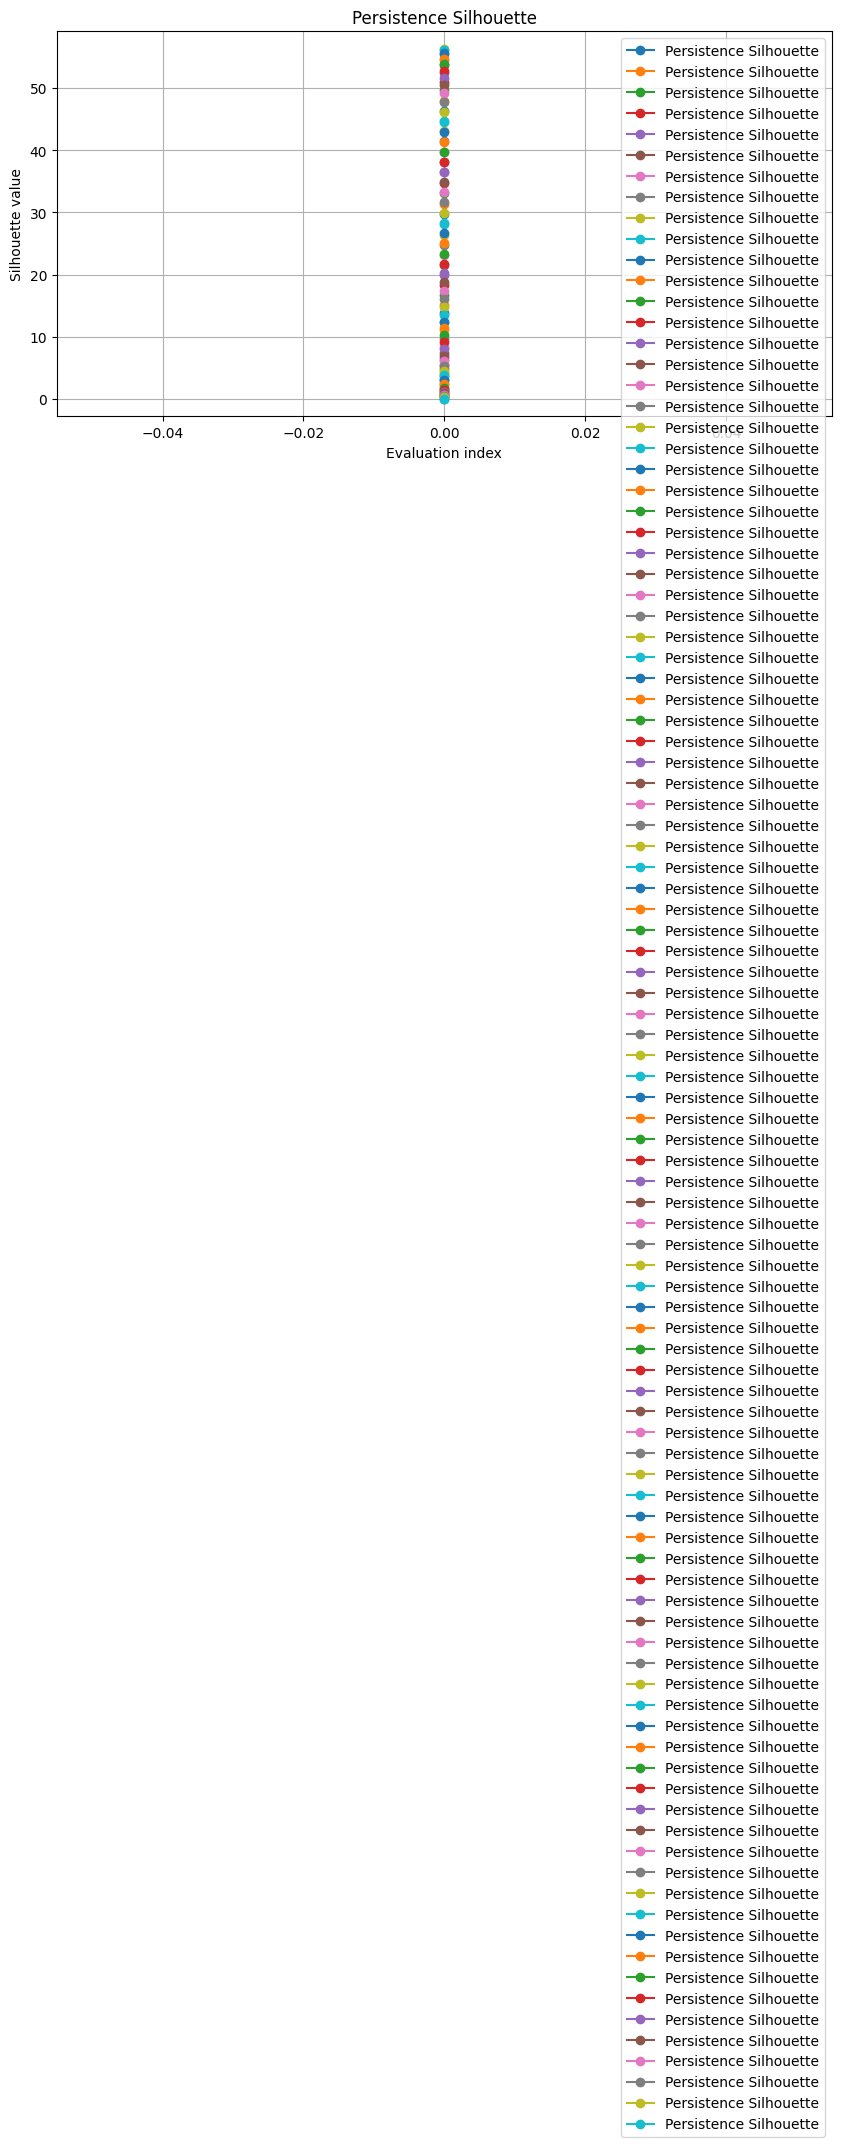

In [26]:
# Plot the silhouette result
plt.figure(figsize=(10, 5))
plt.plot(silhouette_result[0], marker='o', label='Persistence Silhouette')

plt.title("Persistence Silhouette")
plt.xlabel("Evaluation index")
plt.ylabel("Silhouette value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()